# Analysis of counts

## 1. Introduction

In this chapter we discuss the analysis of categorial data, having shown in previous chapters how analyse data measured on a continuous scalre. Suppose the experimental unit is a plant and ten plants receive a particular treatment. We then measure the disease state: healthy or diseased. We may be interested in the proportion of plants which are infected. In germination tests we may wish to compare the proportions of seeds germinating for several treatments. In a genetics experiment we may want to compare the proportions of offspring of various phenotypes. We start by considering attributes which can only have two possible values, how to find confidence intervals for, and test hypotheses about a population proportion. These techniques are based on the theory of the binomial and normal distributions. In later sections the chi-square distribution is used to test goodness of fit and independence in two-way contingency tables.

## 2. The binomial distribution

Consider a series of n independent trials. Assume that there are only two possible outcomes (success or failure) at each trial, and that p is the constant probability of a success. This implies the probability of a failure at each trial is 1 - p (denoted by q). Hence p + q = 1. In this context a trial could be a planting of a seed or the injection of a viral strain into a plant. Success would be germination, or the incidence of a disease. Independence implies that the outcome of any one trial does not influence the outcome of any other.

Let X represent the number of successes in n trials. It is a random variable which could take any value between 0 and n. The probability that X is equal to k is denoted by Pr(X = k), abbreviated $P_k$. The probability of obtaining exactly k successes in the n trials is given by the formula:

$$ P_k = \frac{n!}{k!(n - k)!}p^kq^{(n-k)} $$

When using this formula you need to know the meaning of n! (n factorial). We illustrate the meaning with 4 factorial: $4! = 4 \times 3 \times 2 \times 1 = 24$. You also need to know that $0! = 1$ and $p^0 = 1$.

Let's take an example. Four seeds from the same genotype are planted and treated in the same way. Suppose each has a probability of 0.8 of germinating. Let's find the probability of the number of seeds germinating. In other words, we want $P_k$ for each value of k from 0 to 4.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import t
from scipy.stats import chi2
from scipy.stats import chisquare

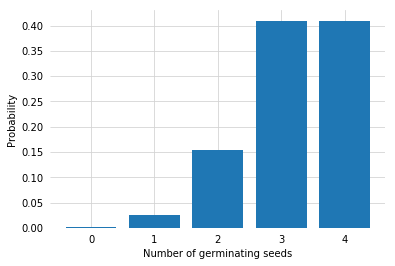

In [20]:
#calculate Pk for each k
k = np.array(list(range(5)))
n = 4
p = 0.8
Pk = binom.pmf(k, n, p)

#display histogram of Pk
fig, ax = plt.subplots()
ax.bar([i for i in range(5)], Pk, zorder=4)
spines = ['right', 'top', 'left', 'bottom']
for spine in spines:
    ax.spines[spine].set_visible(False)
ax.grid(color='lightgrey')
ax.tick_params(axis='both', color='white')
ax.set_xlabel('Number of germinating seeds')
ax.set_ylabel('Probability')
plt.show()

In general the binomial distribution is skew. Let's see $P_k$ values with n = 6 and p = 0.2, 0.3, 0.4, 0.5 and 0.8, respectively. Note that the probabilities for p = 0.2 are identical to those for p = 0.8 but in reverse order.

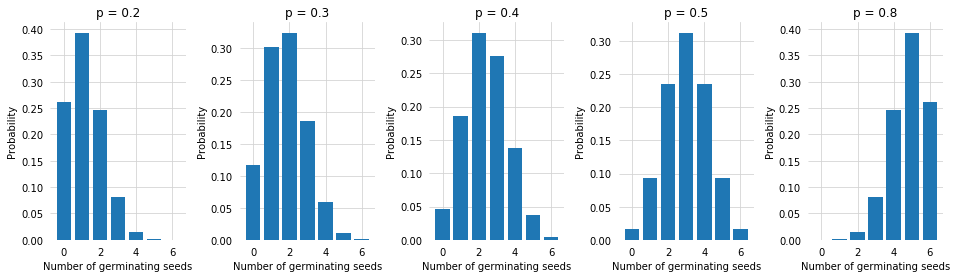

In [41]:
#calculate Pk for each k and p
k = np.array(list(range(7)))
n = 6
p = np.array([0.2, 0.3, 0.4, 0.5, 0.8])
Pk = [0] * 5
for i, proba in enumerate(p):
    Pk[i] = binom.pmf(k, n, proba)
    
#display results on several histograms
fig, axes = plt.subplots(ncols=5, figsize=(16, 4))
for i, ax in enumerate(axes):
    ax.bar([i for i in range(7)], Pk[i], zorder=4)
    spines = ['right', 'top', 'left', 'bottom']
    for spine in spines:
        ax.spines[spine].set_visible(False)
    ax.grid(color='lightgrey')
    ax.tick_params(axis='both', color='white')
    ax.set_xlabel('Number of germinating seeds')
    ax.set_ylabel('Probability')
    ax.set_title('p = {}'.format(p[i]))
plt.subplots_adjust(wspace=0.4)
plt.show()

### 2.1 Mean and variance

It can be shown that the mean of the binomial distribution is $np$ and the variance is $npq$. For example, if we carry out six trials and the probability of success at each trial is 0.2 we would expect 1.2 successes on average. The standard deviation would be $\sqrt{npq}=0.98$.

### 2.2 The normal approximation to the binomial distribution

Provided the number of trials n is large and the probability of success at each trial is not too close to zero or one, probabilities associated with the binomial distribution can be approximated by assuming a normal distribution with mean np and variance npq. In practice, the approximation is acceptable if neither np nor nq is less than five. The probability of k or fewer successes in n independent trials is $Pr(X \leq k ) = P_0 + P_1 + ... P_k$. This can be approximated by finding the area under the normal distribution curve to the left of $k + \frac{1}{2}$. The $\frac{1}{2}$ is the continuity correction reflecting the fact that a discrete distribution is being approximated by a continuous one. The corresponding z-value is:

$$z = \frac{(k + 0.5) - np}{\sqrt(npq}$$

To find $Pr(X \geq k)$ use the equation $Pr(X \geq k) = 1 - PR(X \leq k - 1)$.

Let's find an approximation to the probability of seven or fewer successes in 15 trials with p = 0.4.

In [8]:
#z-value
k = 7
n = 15
p = 0.4
z = (k + 0.5 - n * p) / np.sqrt(n * p * (1 - p))
p_norm = norm.cdf(z)
p_binom = binom.pmf(np.array(list(range(n + 1))), n, p)
print("Pr( X <= 7) using the normal approximation : {:.3f}".format(p_norm))
print("Pr( X <= 7) (exact value) : {:.3f}".format(p_binom[:8].sum()))

Pr( X <= 7) using the normal approximation : 0.785
Pr( X <= 7) (exact value) : 0.787


## 3. Confidence intervals for a proportion

Suppose you have a large batch of seed and wish to know the proportion which will germinate. You could take a random sample of seeds, carry out a germination test to find the proportion germinating and use this as an estimate for the whole batch. The reliability of this estimate depends on the sample size and can be assessed by calculating a confidence interval based on the binomial distribution. For large samples the normal approximation to the binomial distribution can be used provided certain assumptions are made. In the following section it is assumed that the population is large compared to the sample size.

### 3.1 The exact method

Let p be the proportion of the population possessing a certain attribute. For example, a plant may or may not be diseased, an animal may be male or female, a cutting may root or not, etc. In a random sample of size n, let k be the observed number of individuals possessing the attribute. The best estimate of p is $\hat{p} = k / n$. In another sample, it is likely a different value for k would be obtained. Assuming that the possession of the attribute by one individual (success) does not affect that of another, k can be considered to be a value from a binomial distribution with n trials and probability of success at each trial of p. A 95% confidence interval for p can be obtained as follows.

Let $p_L$ and $p_U$ be the required lower and upper confidence limits. $p_U$ is the value of $p$ such that the probability of k or fewer successes in the n trials is 0.0025 and $p_L$ is that  value of $p$ such that the probability of k or more successes in the n trials is 0.025. 

Let's illustrate this with the follwing example. A random sample of 20 seeds is taken and four germinate. The point estimate is 4 / 20 = 0.2. To find $p_U$ we need to find that value of $p$ for a binomial distribution with n = 20 such that the probability of getting four or fewer successes is 0.025. In other words we have to solve the equation $0.025 = P_0 +  P_1 + P_2 + P_3 + P_4$. To find $p_L$ we need to find that value of $p$ for a binomial distribution with n = 20 such that the probability of getting four or more successes is 0.025. This is 1 minus the probability of getting three or fewer successes we need p such that $0.975 = P_0 + P_1 + P_2 + P_3$. Note that this confidence interval is not symmetrical around 0.2 (it would have if the observed proportion was 0.5). The interval is not unique. Another 95 % confidence interval is obtained by replacing 0.025 and 0.025 in the calculation of $p_U$ and $p_L$ by 0.01 and o.04 to give $p_L = 0.07$ and $p_U = 0.48$. Any combination could be used provided they add to 0.05, but it is traditional to use 0.025 and 0.025.

In [48]:
#confidence intervals on a probability
n = 20
k = 4
level = 0.05
p_upper = beta.ppf(1 - level / 2, k + 1, n - k)
p_lower = beta.ppf(level / 2, k, n - k + 1)
print('95% confidence interval of p with n = 20 and k = 4: {:.4f} - {:.4f}'.format(p_lower, p_upper))

95% confidence interval of p with n = 20 and k = 4: 0.0573 - 0.4366


### 3.2 The approximate method

The exact method is rather difficult to understand and use. Fortunately there is a much easier method which gives almost the same results provided n is large and the observed proportion $\hat{p}$ is not too close to 0 or 1. In practice if neither $n\hat{p}$ nor $n(1-\hat{p})$ is than than 5 we can use the normal approximation to the binomial distribution. Provided the population is large compared to the sample we can assume that k follows approximately a normal distribution with mean $np$ and variance $npq$. This implied that $k/n$ follows a normal distribution with mean $p/n = p$ and variance $npq/n^2 = pq/n$ where $q = 1 - p$.

Approximate confidence interval for a population proportion can be obtained by assuming that $\hat{p}$ comes from a normal distribution with a mean of $p$ and a standard deviation of $\sqrt{pq/n}$. As $p$ is unkown a further approximation is obtained by using the sample estimate $\hat{p}$. Hence an approximate 95% confidence interval for $p$ is $p \pm 1.96 \sqrt{\hat{p}\hat{q}/n}$.
An approximate 99% confidence interval is obtained by replacing 1.96 by 2.58 in the above formula. The value of $\sqrt{\hat{p}\hat{q}/n}$ is called the standard error of the proportion.

**Caution**: the calculation are very wrong if the assumptions of the normal approximation are not met.

Let's take an example. In a random sample of 200 seeds taken from a large batch, 120 were found to germinate.

In [51]:
#calculate 99% confidence interval
n = 200
k = 120
p = k / n
q = 1 - p
p_lower = p - np.sqrt(p * q / n)
p_higher = p + np.sqrt(p * q / n)
print("p = {:.4f}".format(p))
print("99% confidence interval (n = 200, k = 120) : {:.4f} - {:.4f}".format(p_lower, p_higher))

p = 0.6000
99% confidence interval (n = 200, k = 120) : 0.5654 - 0.6346


### 3.3 Estimation of sample size

Suppose you want to ensure that whatever the true population proportion, a 95% confidence interval extends no further than $\delta$ on each side of the sample proportion. How many sample observations should we take? Using the normal approximation we require n such that:

$$ 1.96 \times \sqrt{\frac{pq}{n}} < \delta $$

$$ n \geq  \frac{1.96^2 \times pq}{\delta^2} $$

Although p is unknown, pq has a maximum value of 0.25 when p = 0.5. For example, if p = 0.5 and you set $\delta$ to 0.04, you will need a sample size of at least 600. If p is any other value the required sample size will be smaller.

## 4. Hypothesis test of a proportion

To test whether a population proportion is a particular value $p_0$, we could find a 95% confidence interval for the true proportion $p$. If $p_0$ is not in the interval we would reject the null hypothesis at the 5% level on a two-tailed test. Alternatively we could proceed as follows.

### 4.1 Large-sample test

Set up the null hypothesis that the population proportion $p$ is $p_0$ and decide on a level of significance, say 5%. Also decide on a one- or two-tailed alternative. Take a large random sample of size n and count the number of individuals k with the chosen attribute. The observed proportion is thus $\hat{p} = k / n$. This is approximately normally distributed with a mean $p_0$ and a standard deviation $\sqrt{p_0q_0/n}$ if the null hypothesis is true and assuming the conditions for the normal approximation to the binomial distribution hold. Hence the test statistic is :

$$ z = \frac{\hat{p} - p_0}{\sqrt{p_0q_0/n}} $$

If the test is two tailed at the 5% level, we reject the null hypothesis if the magnitude of z is greater than 1.96. If it is one-tailed with the alternative that $p$ is greater than $p_0$ we reject at the 5% level if z is greater than 1.65.

Let's take an example. A plant breeder wishes to know whether a single gene is responsible for the stem colour of a tomato plant. Genetic theory predicts a cross of two parents should result in seedlings which are purple and green-stemmed in the ratio 3:1. The offspring consisted of 112 purple and 46 green-stemmed seedlings.

In [74]:
#testing if a single gene controls stem colour
def approximate_test(k, n, p_null):
    """Tests if an experimental proportion is equal to a reference proportion.
    k : number of successes
    n : number of trials
    p_null : expected proportion"""
    p = k / n
    z = (p - p_null) / np.sqrt(p_null * (1 - p_null) / n)
    p_val = 2 * t.cdf(z, n - 1)
    conf_inter = "{:.3f} - {:.3f}".format(p - np.sqrt(p * q / n), p + np.sqrt(p * q / n))
    
    print("Test of p = {0} vs p not = {0}".format(p_null))
    print("{:>10}{:>10}{:>10}{:>15}{:>10}{:>10}".format("Successes", "Trials", "Sample p", "95% CI", "z-value", "p-value"))
    print("{:>10}{:>10}{:>10.3f}{:>15}{:>10.3f}{:>10.3f}".format(k, n, p, conf_inter, z, p_val))
    
approximate_test(112, 158, 0.75)

Test of p = 0.75 vs p not = 0.75
 Successes    Trials  Sample p         95% CI   z-value   p-value
       112       158     0.709  0.666 - 0.751    -1.194     0.234


### 4.2 Small-sample test

The use of the normal approximation may lead to false conclusions when small samples are involved. The exact test makes use of the binomial distribution.

A manufacturer claims a plant growth hormone will cause at least 90% of cuttings to root. However, when ten identical cuttings are treated only seven root. Should you reject the claim based on this evidence? The null hypothesis is that p = 0.9 versus the alternative that p is less than 0.9. You carry out a one-tailed test because you will only refute the claim if a significantly smaller proportion than 0.9 root. The sample proportion is 0.7 so we need to find the probability of obtaining a proportion as low as this or lower when the population proportion is 0.9. This is the same as observing seven or fewer successes in a binomial distribution with n = 10 and p = 0.9. Note that is we perform the same analysis using the approximate test, we get a significant p-value, which leads to a false conclusion.

In [95]:
#testing if plant hormone claim is correct
def exact_test(k, n, p_null):
    """Tests if an experimental proportion is equal to a reference proportion.
    k : number of successes
    n : number of trials
    p_null : expected proportion"""
    level = 0.05
    p = k / n
    p_val = binom.pmf(np.array(list(range(n + 1))), n, p_null)
    conf_inter = "{:.3f} - {:.3f}".format(beta.ppf(level / 2, k, n - k + 1), beta.ppf(1 - level / 2, k + 1, n - k))
    
    print("Test of p = {0} vs p not = {0}".format(p_null))
    print("{:>10}{:>10}{:>10}{:>15}{:>10}".format("Successes", "Trials", "Sample p", "95% CI", "p-value"))
    print("{:>10}{:>10}{:>10.3f}{:>15}{:>10.3f}".format(k, n, p, conf_inter, p_val[:k + 1].sum()))

exact_test(7, 10, 0.9)

Test of p = 0.9 vs p not = 0.9
 Successes    Trials  Sample p         95% CI   p-value
         7        10     0.700  0.348 - 0.933     0.070


## 5. Comparing two proportions

A random sample of size $n_1$ is taken from population 1 and the number of successes $k_1$ is noted. An independent sample of size $n_2$ is taken from population 2 and the number of successes $k_2$ is counted. The unknown population proportions are $p_1$ and $p_2$ and the sample proportions are $\hat{p}_1 = k_1 / n_1$ and $\hat{p}_2 = k_2 / n_2$. An approximate 95% confidence interval for $p_1 - p_2$ is given by:

$$ (\hat{p}_1 - \hat{p}_2) \pm 1.96 \sqrt{\frac{\hat{p}_1\hat{q}_1}{n_1} + \frac{\hat{p}_2\hat{q}_2}{n_2}} $$

where $\hat{q}_1 = 1 - \hat{p}_1$ $\hat{q}_2 = 1 - \hat{p}_2$.

A 99% confidence interval is obtained by replacing 1.96 by 2.58. The approximation is not good if the observed proportions are near 0 or 1 of if the samples are small.

Let's take an example. An experiment is conducted to compare two seed dressings on the viability of wheat seeds. One hundred seeds of a particular variety are randomly divided into two groups of 50 each. One group is given treatment one and the other treatment two. Subsequently, all the seeds are left to germinate on a moistened filter paper. It is found that 80% of the seeds given treatment one and 66% of those given treatment two germinate.

In [100]:
#calculation of a 95% confidence interval
p1 = 0.8
q1 = 1 - p1
p2 = 0.66
q2 = 1 - p2
n1 = 50
n2 = 50
ci_low = abs(p1 - p2) - 1.96 * np.sqrt(p1 * q1 / n1 + p2 * q2 / n2)
ci_high = abs(p1 - p2) + 1.96 * np.sqrt(p1 * q1 / n1 + p2 * q2 / n2)
print("95% confidence interval : {:.3f} - {:.3f}".format(ci_low, ci_high))

95% confidence interval : -0.032 - 0.312


We are 95% confident that the proportion of germinating seedlings lie between 31% in favour of treatment one of 3% in favour of treatment two. As this interval includes zero we cannot reject at the 5% level the null hypothesis. We would detect a significant difference with a sample size of 80 and the same proportions, indicating that large samples are required to detect small differences. While this method can be used to carry out hypothesis tests to compare two population proportions, the contingency table method (section 9) is more commonly used.

## 6. The chi-square goodness of fit test

This test is used to compare observed frequencies (O) in several categories (cells) corresponding with expected frequencies(E). The expected frequencies are calculated assuming a particular null hypothesis to be true. Under the null hypothesis you would expect the O and E values to be close together. To test the null hypothesis the following quantity is calculated:

$$ \chi^2 = \sum \frac{(O - E)^2}{E} $$

This is the calculated chi-square which can be assumed to come approximately from a $\chi^2$ distribution if the null hypothesis is true. The degrees of freedom, $\nu$, is the number of cells minus the number of sample constants used to calculate the expected frequencies, which add to the sum of the observed frequencies. The null hypothesis is rejected if the value of $\chi^2$ is sufficiently large, reflecting a significant discrepancy between observed and expected frequencies, hence the test is one-tailed. This approximate test is not reliable when some expected frequencies are less than 5. Some statisticians do not recommend using this test if more than 20% of the expected frequencies are less than 5, especially if these cells make a large contribution to the total chi-square value. The test should not be used if any cells have expected frequencies less than 1. However, in some situations cells with low expected frequencies may be combined.

### 6.1 Goodness of fit with two categories

The simplest application of the chi-square goodness of fit test is the test of the null hypothesis that a population proportion is a specified value. It is equivalent to the test described in section 4.1 and is only valid if the conditions for the normal approximation to the binomial distribution apply. Let's reuse the example of purple and green stem color on seedlings. The test has one degree of freedom because there are two categories and the sample total was used to calculated the expected frequencies. This ensures that the sum of the observed is equal to the sum of the expected frequencies. Note that the square root of 1.426 is 1.19, the z-value in our previous calculation, showing that the two tests are equivalent.

In [27]:
#goodness of fit test on two categories
def gof_2cat(k, n, p_exp, console=True):
    """Perform a goodness of fit test on two categories.
    k : (integer) number of successes
    n : (integer) number of trials
    p_exp : (float) expected probability of success
    console : (boolean) True if results should be printed on the console
    """
    
    #calculated observed and expected values
    obs = np.array([k, n - k])
    exp = np.array([p_exp * n, (1 - p_exp) * n])
    
    #calculate chi-square
    chi_sq = np.sum((obs - exp) ** 2 / exp)
    
    #calculate p-value
    p_val = 1 - chi2.cdf(chi_sq, 1)
    
    if console:
        print('Chi-square goodness of fit test on two categories')
        print('{:>10}{:>10}{:>12}{:>10}{:>10}'.format('Observed X', 'Trials', 'Expected X', 'Chi2', 'p-value'))
        print('{:>10}{:>10}{:>12.2f}{:>10.3f}{:>10.5f}'.format(k, n, exp[0], chi_sq, p_val))
    
    return chi_sq, p_val

In [29]:
_ = gof_2cat(112, 158, 0.75)

Chi-square goodness of fit test on two categories
Observed X    Trials  Expected X      Chi2   p-value
       112       158      118.50     1.426   0.23239


### 6.2 Continuity correction

The $\chi ^2$ distribution is continuous whereas the calculated values are discrete. If the observed frequencies in the previous example had changed by 1 to 113 and 45, the calculated chi-square would have changed from 1.426 to 1.021, a discrete jump. With a total of 158 plants and expected frequencies of 118.5 and 39.5 it is not possible to obtain a calculated chi-square between these values. When the degrees of freedom is 1, a continuity correction is recommended where, for each cell, the magnitude of the difference between the observed and expected values is reduced by 0.5 before squaring. This reduces the value of chi-square and so makes the test more conservative. Let's calculate the adjusted chi-square for our example. Despite a descrease in the $\chi ^2$ value and an increase in the p-value, our conclusion holds true.

In [31]:
#calculation of adjusted square (continuity correction)
def gof_2cat_adj(k, n, p_exp, console=True):
    """Perform a goodness of fit test on two categories with continuity correction.
    
    Parameters
    k : (integer) number of successes
    n : (integer) number of trials
    p_exp : (float) expected probability of success
    console : (boolean) True if results should be printed on the console
    
    Returns
    chi-square : adjusted chi-square value
    p-value
    """
    
    #calculated observed and expected values
    obs = np.array([k, n - k])
    exp = np.array([p_exp * n, (1 - p_exp) * n])
    
    #calculate chi-square
    chi_sq = np.sum(((abs(obs - exp) - 0.5) ** 2 / exp))
    
    #calculate p-value
    p_val = 1 - chi2.cdf(chi_sq, 1)
    
    if console:
        print('Chi-square goodness of fit test on two categories')
        print('{:>10}{:>10}{:>12}{:>10}{:>10}'.format('Observed X', 'Trials', 'Expected X', 'Chi2', 'p-value'))
        print('{:>10}{:>10}{:>12.2f}{:>10.3f}{:>10.5f}'.format(k, n, exp[0], chi_sq, p_val))
    
    return chi_sq, p_val

In [32]:
_ = gof_2cat_adj(112, 158, 0.75)

Chi-square goodness of fit test on two categories
Observed X    Trials  Expected X      Chi2   p-value
       112       158      118.50     1.215   0.27031


### 6.3 Goodness of fit with more than two categories

The same chi-square test is used as for two categories. The degrees of freedom are the number of cells (categories) minus the number of data restrictions used to calculate the expected frequencies.

A parental cross is expected to produce progeny in categories A, B, C, D with a ratio 9:3:3:1. The observed frequencies of 250 progenies were 150, 42, 50, 8.

In [29]:
#goodness of fit test with four categories

def goodness_fit(observed, p_exp, console=True):
    """Perform a goodness of fit test on two categories with continuity correction.
    
    Parameters
    observed : (numpy array) frequencies for each category
    p_exp : (numpy array) expected frequencies for each category
    console : (boolean) True if results should be printed on the console
    
    Returns
    chi-square : adjusted chi-square value
    p-value
    """
    
    #expected frequencies
    expected = observed.sum() * p_exp
    
    #print word of caution if any frequency is less than 5
    if any(expected < 5):
        print("Caution : some expected frequencies are less than 5.\n")
    
    #calculate chi-square
    chi_sq = np.sum(((observed - expected) ** 2 / expected))
    
    #degrees of freedom
    df = observed.size - 1
    
    #calculate p-value
    p_val = 1 - chi2.cdf(chi_sq, df)
    
    if console:
        print('Chi-square goodness of fit test on {} categories'.format(df + 1))
        print('Chi-square : {:.3f} on {} df'.format(chi_sq, df))
        print('p-value : {:.5f}'.format(p_val))
    
    return chi_sq, p_val

In [14]:
#observed frequencies
observed = np.array([150, 42, 50, 8])

#frequency model
model = np.array([9/16, 3/16, 3/16, 1/16])

_ = goodness_fit(observed, model)

Chi-square goodness of fit test on 4 categories
Chi-square : 5.061 on 3 df
p-value : 0.16736


### Testing the fit to a binomial distribution

Consider an experiment in which 100 pots are each planted with six seeds of one barley variety and the growing conditions are uniform. If the probability of any given seed germinating is 0.8 and the seeds germinate independently you would expect the number of seeds germinating in any particular pot to follow a binomial distribution with probabilities given on the second figure of section 2.

In [30]:
#testing the fit to the binomial distribution
observed = np.array([0, 2, 3, 12, 19, 43, 21])
model = binom.pmf(list(range(7)), 6, 0.8)
_ = goodness_fit(observed, model)

Caution : some expected frequencies are less than 5.

Chi-square goodness of fit test on 7 categories
Chi-square : 28.014 on 6 df
p-value : 0.00009


Since we obtained a very low p-value we are tempted to conclude there is very strong evidence against the null hypothesis. However, there are three expected frequencies less than 5, of which two are less than 1, so the test is unreliable. When an expected frequency is less than 1 a change in O of 1 can have a large effect on $\chi ^2$. In this example if the O corresponding to k = 1 had been 1 instead of 2, its contribution to $\chi ^2$ would have been 4.648 instead of 22.128 and a non-significant result probably obtained. A more reliable test is to combine the cells with expected frequencies less than 5 to obtain O = 0 + 2 + 3 = 5 and E = 0.006 + 0.154 + 1.536 = 1.696. The corresponding $(O - E)^2/E$ is 6.437. On adding this to the values for k = 3 to 6 the calculated $\chi ^2$ is 10.853. The degrees of freedom are reduced to 4. The p-value still indicates a significant result. However, the expected frequency of 1.696 is still less than five so some authors would recommend a further combination. If the cell with k = 3 is also combined, this time the result is not significant, which is probably the most realistic conclusion.

## 7. r x c contigency tables

Each member of a sample is classified according to two criteria. In general, the first criterion has r classes and the second has c classes. The observed frequencies (counts) can then be summarised in a contingency table having r rows and c columns. The data may arise as the result of a survey or an experiment, and the chi-square goddness-of-fit test can be used to test whether the two criteria of classification are independent or associated. In some cases the row totals or column totals are fixed in advance and sometimes just the grand total is fixed. If any row or column consists entierely of zeros it should be deleted. Misleasing conclusions may also be made if the table contains some cells with very small counts. If the table has two rows or two columns the test can be used to compare two or more proportions. Importantly, the data in a contingency table must be in the form of counts for the chi-square test to be valid. Do not use proportions or percentages in the formula for chi-square.

For example, we wish to know whether seed colour and petal colour in field beans are associated. If they are independent (not associated) then knowledge of seed colour would give no information about petal colour. You carry out a survey in which you obtain a random sample of 500 bean plants from the population of interest and classify each plant according to seed colour and petal colour. Suppose we obtaine the following results.

In [42]:
#dataframe containing bean seed and petal colour
beans = pd.DataFrame({'petal': np.repeat(['purple', 'mauve', 'white'], 4),
                      'seed': np.array(['dark brown', 'brown', 'light brown', 'white'] * 3),
                      'counts': [21, 32, 13, 4,
                                 55, 102, 70, 8,
                                 14, 59, 112, 10]})
beans_tab = pd.pivot_table(beans, values='counts', index='petal', columns='seed')
beans_tab

seed,brown,dark brown,light brown,white
petal,,,,
mauve,102,55,70,8
purple,32,21,13,4
white,59,14,112,10


In [69]:
#goodness-of-fit test on a r x c contingency table
def gof_table(table, console=True):
    """
    Performs a goodness-of-fit test on a contingency table.
    
    table : pandas dataframe
    """
    
    #number of rows an columns
    rows, cols = table.shape
    
    #degrees of freedom
    df = (rows - 1) * (cols - 1)
    
    #sum of values of the whole table
    total = table.sum().sum()
    
    #count of cells with expected counts < 5
    caution = 0
    
    #initialize chi-square at 0 and add values by iterating through the table
    chi_sq = 0
    for r in range(rows):
        for c in range(cols):
            observed = table.iloc[r, c]
            expected = table.iloc[r, :].sum() * table.iloc[:, c].sum() / total
            if expected < 5:
                caution += 1
            chi_sq += (observed - expected) ** 2 / expected
            
    p_val = 1 - chi2.cdf(chi_sq, df)
    
    if console:
        print("Goodness-of-fit test")
        print("Chi-square : {:.3f} on {} df".format(chi_sq, df))
        print("p-value : {:.5f}\n".format(p_val))
        if caution > 0:
            print("Caution : {} cells with expected counts less than 5.".format(caution))
    
    return chi_sq, p_val

In [70]:
_ = gof_table(beans_tab)

Goodness-of-fit test
Chi-square : 58.575 on 6 df
p-value : 0.00000

Caution : 1 cells with expected counts less than 5.


## 8. 2 x c contingency tables : comparison of several proportions